# RAPL Energy Consumption

**Note:** this notebook is meant to be executed on the supplied Docker image.

In [2]:
import os
from pathlib import Path
import time
import math
from matplotlib import pyplot as plt
import subprocess
import numpy as np


This notebook provides ...

## RAPL sysfs Interface

Set the `cpu_zone` as in lab 02:

In [3]:
cpu_zone = '/sys/devices/virtual/powercap/...'  # complete this path

Let's verify whether this zone seems like the zone of your CPU.

In [5]:
if os.path.isdir(cpu_zone):
    print('✓ Zone exists')
else:
    print('✗ Zone does not exist!')

name = Path(f'{cpu_zone}/name').read_text().strip()

if name.startswith('package-'):
    print('✓ Its name starts with \'package-\'')
else:
    print('✗ Its zone does not start with \'package-\'!')

if os.path.isfile(f'{cpu_zone}/energy_uj'):
    print('✓ File \'energy_uj\' exists')
else:
    print('✗ File \'energy_uj\' does not exist!')

✗ Zone does not exist!


FileNotFoundError: [Errno 2] No such file or directory: '\\sys\\devices\\virtual\\powercap\\...\\name'

Complete the following code as in lab 02

In [95]:
from random import randrange


def energy_uj():
    return randrange(300)
    #TODO verify
   # with open(f"{cpu_zone}/energy_uj") as energy_file:
   #     return int(energy_file.readline())

def mock_energy(time, powercap):
    print(time*powercap)
    return 8 * time * powercap + randrange(80)

print(f'Current energy counter value: {energy_uj()}')

def max_energy():
    return 300
    #TODO verify
   # with open(f"{cpu_zone}/max_energy_range_uj") as file:
   #     return int(file.readline())

def energy_consumption(energy_uj_start, energy_uj_end):
    #TODO verify
    # return randrange(300)
    return energy_uj_end - energy_uj_start if energy_uj_end > energy_uj_end else max_energy() - energy_uj_start + energy_uj_end

Current energy counter value: 188


In [96]:
def set_powercap(watts_limit: int):
    pass
    #TODO short term vs long term?
    # with open(f"{cpu_zone}/constraint_1_power_limit_uw", "w") as file:
    #    return file.write(watts_limit * 1000_000)

In [121]:
def edp(energy: float, time: float):
    return energy * time

def chASz(energy: float, time: float, min_energy: float, init_time: float):
    return (energy - min_energy * 0.9) * (time - init_time * 0.9)

def eds(energy: float, time: float, alpha: float, beta: float):
    return alpha * energy + beta * time

def edd(energy: float, time: float, alpha: float, beta: float):
    return math.sqrt((alpha * energy)**2 + (beta * time)**2)

def percent_diff(energy: float, time: float, init_energy: float, init_time: float):
    return (init_energy-energy)/init_energy - (time - init_time)/init_time


48.040504455566406
39.36213970184326
34.859886169433594
30.935311317443848
27.83529281616211
27.477097511291504
24.68372344970703
24.680657386779785


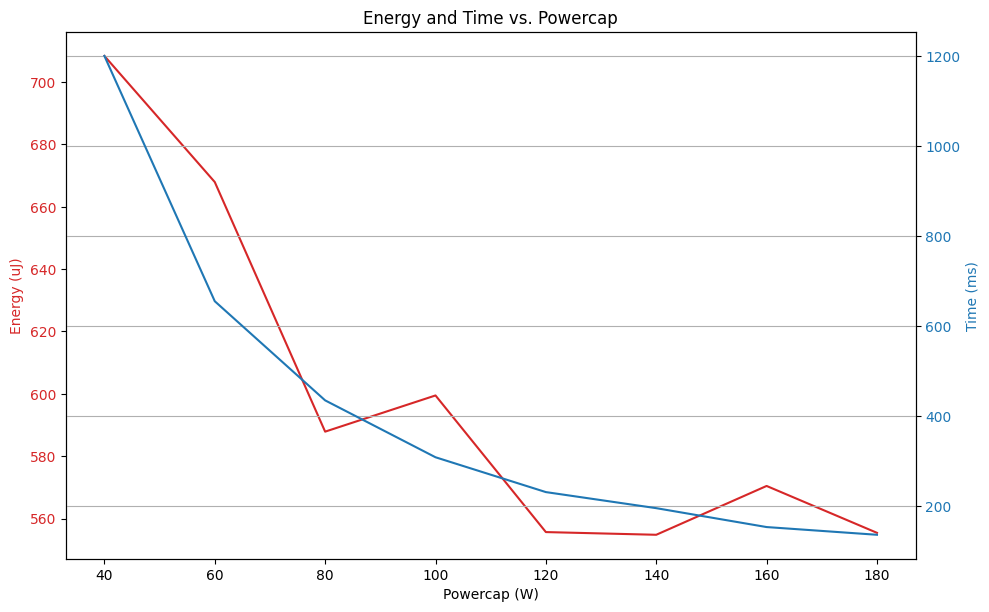

In [116]:


def run_task(*args):
    # time.sleep(0.05)
    time.sleep(0.05 + randrange(10)/100)
    # subprocess.call(['eumaster4hpc-task', *args])

def benchmark_once(powercap_w: int, *args):
    set_powercap(powercap_w)

    time1 = time.time()
    energy1 = 0
    # energy1 = energy_uj()
    time.sleep(300/powercap_w**1.5)
    # run_task(*args)
    time2 = time.time()
    # energy2 = energy_uj()


    total_time = time2 - time1
    energy2 = mock_energy(total_time, powercap_w)
    total_energy = energy_consumption(energy1, energy2)

    return total_time * 1000, total_energy


tested_powercaps = [i for i in range(40, 200, 20)]

energies = []
times = []


for powercap in tested_powercaps:
    time_result, energy_result = benchmark_once(powercap)
    energies.append(energy_result)
    times.append(time_result)

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Powercap (W)')
ax1.set_ylabel('Energy (uJ)', color=color)
ax1.plot(tested_powercaps, energies, color=color, label='Energy')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Time (ms)', color=color)
ax2.plot(tested_powercaps, times, color=color, label='Time')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Energy and Time vs. Powercap')
plt.grid(True)
plt.show()

In [126]:
edps = []
eds_values = []
edds = []
percent_diffs = []
chASzs = []

initial_time, initial_energy = times[-1], energies[-1]
alpha = 0.5  # You can adjust these coefficients according to your needs
beta = 0.5

for i in range(len(times)):
    time_result, energy_result = times[i], energies[i]
    edps.append(edp(energy_result, time_result))
    chASzs.append(chASz(energy_result, time_result, min(energies), initial_time))
    eds_values.append(eds(energy_result, time_result, alpha, beta))
    edds.append(edd(energy_result, time_result, alpha, beta))
    percent_diffs.append(percent_diff(energy_result, time_result, initial_energy, initial_time))


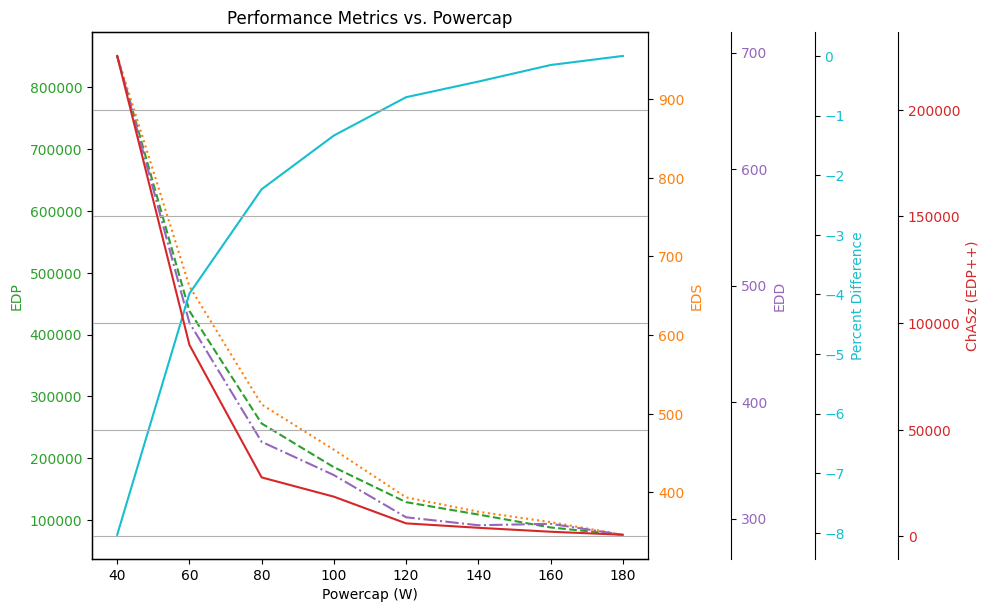

In [127]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Powercap (W)')

# EDP plot
color = 'tab:green'
ax1.set_ylabel('EDP', color=color)
ax1.plot(tested_powercaps, edps, color=color, linestyle='--', label='EDP')
ax1.tick_params(axis='y', labelcolor=color)

# EDS plot
ax4 = ax1.twinx()
color = 'tab:orange'
ax4.spines['right'].set_position(('outward', 0))
ax4.set_ylabel('EDS', color=color)
ax4.plot(tested_powercaps, eds_values, color=color, linestyle=':', label='EDS')
ax4.tick_params(axis='y', labelcolor=color)

# EDD plot
ax5 = ax1.twinx()
color = 'tab:purple'
ax5.spines['right'].set_position(('outward', 60))
ax5.set_ylabel('EDD', color=color)
ax5.plot(tested_powercaps, edds, color=color, linestyle='-.', label='EDD')
ax5.tick_params(axis='y', labelcolor=color)

# Percent Difference plot
ax6 = ax1.twinx()
color = 'tab:cyan'
ax6.spines['right'].set_position(('outward', 120))
ax6.set_ylabel('Percent Difference', color=color)
ax6.plot(tested_powercaps, percent_diffs, color=color, linestyle='-', label='Percent Difference')
ax6.tick_params(axis='y', labelcolor=color)

ax7 = ax1.twinx()
color = 'tab:red'
ax7.spines['right'].set_position(('outward', 180))
ax7.set_ylabel('ChASz (EDP++)', color=color)
ax7.plot(tested_powercaps, chASzs, color=color, linestyle='-', label='ChASz (EDP++)')
ax7.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Performance Metrics vs. Powercap')
plt.grid(True)
plt.show()

354.1630178222656


C:\Users\Jasiek\AppData\Local\Temp\ipykernel_5876\3031336279.py:17: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(c**2 - (alpha*E)**2)/beta
C:\Users\Jasiek\AppData\Local\Temp\ipykernel_5876\3031336279.py:30: RuntimeWarning: divide by zero encountered in scalar divide
  return c/(E-omega) + theta


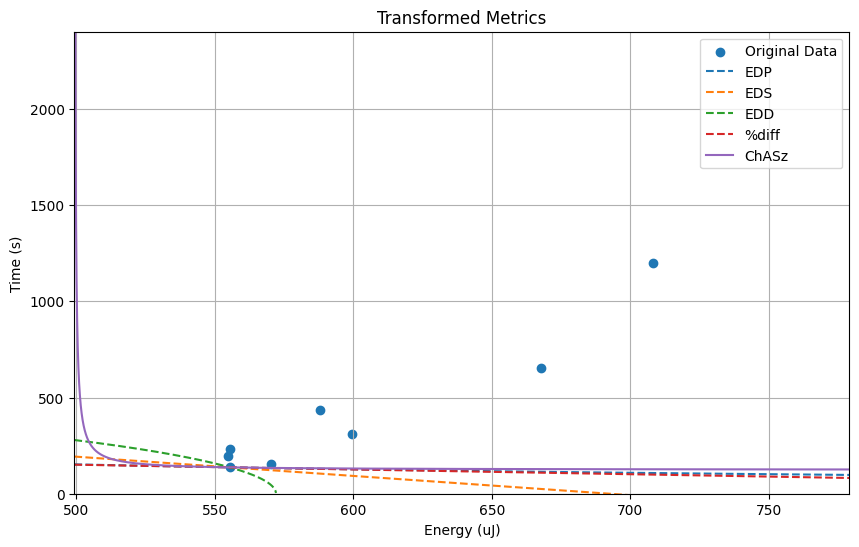

In [128]:

def trans_edp(E):
    # c = 500
    c = min([edp(e, t) for e, t in zip(energies, times)])
    omega = 0 # min(energies) - 1
    theta = 0 # min(times) - 1
    return c/(E-omega) + theta

def trans_eds(E):
    # c = -390
    c = min([eds(e, t, alpha, beta) for e, t in zip(energies, times)])
    return -alpha/beta * E + c/beta

def trans_edd(E):
    # c = alpha * max(energies) + 0.001
    # c =  370
    c = min([edd(e, t, alpha, beta) for e, t in zip(energies, times)])
    return np.sqrt(c**2 - (alpha*E)**2)/beta

def trans_percent_diff(E):
    # c = 10
    c = max([percent_diff(e, t, initial_energy, initial_time) for e, t in zip(energies, times)])
    return c + (initial_energy - E)/initial_energy * initial_time + initial_time


def trans_chasz(E):
    # c = 500
    c = min([chASz(e, t, min(energies), initial_time) for e, t in zip(energies, times)])
    omega = min(energies) * 0.9  # min(energies) - 1
    theta = initial_time * 0.9# min(times) - 1
    return c/(E-omega) + theta

print(alpha * max(energies) + 0.001)

transformed_metrics = {"EDP": trans_edp, "EDS": trans_eds, "EDD": trans_edd, "%diff": trans_percent_diff, "ChASz": trans_chasz}


# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot original data
ax.scatter(energies, times, label='Original Data', color='tab:blue')
ax.set_ylim([0, max(times) * 2] )
ax.set_xlim([0.9 * min(energies), max(energies) * 1.1] )

# Plot transformed metrics
for label, metric_func in transformed_metrics.items():
    energy_range = np.linspace(0.9 * min(energies), max(energies) * 1.1, 20000)
    time_range = [metric_func(energy) for energy in energy_range]
    ax.plot(energy_range, time_range, label=label, linestyle="-" if label == "ChASz" else '--')

ax.set_xlabel('Energy (uJ)')
ax.set_ylabel('Time (s)')
ax.set_title('Transformed Metrics')
ax.legend()
plt.grid(True)
plt.show()